In [1]:
import pandas as pd
from plot_params import *
import pandas as pd
data=pd.read_csv(outdir / 'Human_annotated.csv.gz')

outdir = Path('/tscc/nfs/home/hsher/ps-yeolab5/karen_data/eclip_model_scores_human/output/')
for f in outdir.glob('*.score.csv'):
    name = f.name.split('.')[0]
    df = pd.read_csv(f,
                    index_col = 0)
    df.set_index('ID', inplace = True)
    df.rename({'dlogodds_pred': name}, axis = 1, inplace = True)


    data[name]=df[name]

/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/lib/python3.7/site-packages/ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  from ipykernel import kernelapp as app


In [2]:
data['annotation']=data.apply(
    lambda row: 'UTR5' if row['start_annotation']=='UTR5' and row['end_annotation']=='UTR5' else
     'UTR3' if row['start_annotation']=='UTR3' and row['end_annotation']=='UTR3' else 'CDS', axis = 1)

In [3]:
# data.to_csv(outdir / 'Human_annotated_RBPNet.csv.gz')

<AxesSubplot:>

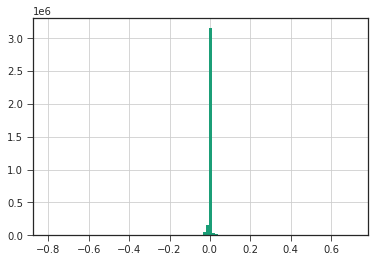

In [4]:
data['difference'].hist(bins = 100)

In [5]:
import numpy as np
data['difference_bin'] = pd.cut(data['difference'], bins = [-np.inf, -0.1, 0.1, np.inf],
                               labels = ['<-0.1', 'middle', '>0.1'])

In [14]:
from scipy.stats import ks_2samp
from statsmodels.stats.multitest import fdrcorrection
fdr_thres = 0.2
stat_all = []
for exp in data.columns[9:-2]:
    for cat in ['<-0.1', '>0.1']:
        sample = data.loc[(data['difference_bin']==cat),
                                    exp]
        bg = data.loc[          
                                    (data['difference_bin']=='middle'), exp]
        ks, pv = ks_2samp(sample, 
                          bg, alternative='two-sided')
        
        median_difference = sample.median() - bg.median()
        stat_all.append([ks, pv, exp, cat, median_difference])
        
stat_all = pd.DataFrame(stat_all, 
                        columns = ['KS statistics', 'pvalue', 'RBPNet_model', 'category', 'median difference'])




In [22]:
stat_all['sig'],stat_all['FDR'] = fdrcorrection(stat_all['pvalue'], alpha = fdr_thres)
#stat_all['l2or'] = np.log2(stat_all['odds ratio'])
stat_all['-log10 FDR']= -np.log10(stat_all['FDR']+stat_all.loc[stat_all['pvalue']>0, 'pvalue'].min())

In [24]:
stat_all.loc

,KS statistics,pvalue,RBPNet_model,category,median difference,sig,FDR,-log10 FDR
0,0.216065,0.000000e+00,DDX41_K562_5081,<-0.1,0.081023,True,0.000000e+00,320.567435
1,0.229187,2.107696e-185,DDX41_K562_5081,>0.1,0.084022,True,5.135653e-185,184.289404
2,0.130995,6.590994e-201,AQR_HepG2_ENCSR018WPY,<-0.1,0.011737,True,1.652525e-200,199.781852
3,0.112575,1.147919e-44,AQR_HepG2_ENCSR018WPY,>0.1,0.009870,True,1.341825e-44,43.872304
4,0.086544,9.456097e-88,HNRNPU_HepG2_ENCSR240MVJ,<-0.1,-0.011314,True,1.298337e-87,86.886613
...,...,...,...,...,...,...,...,...
341,0.052587,4.575525e-10,PTBP1_K562_5015,>0.1,0.008614,True,4.739915e-10,9.324229
342,0.195955,0.000000e+00,BUD13_K562_ENCSR663WES,<-0.1,0.083937,True,0.000000e+00,320.567435
343,0.207981,1.961457e-152,BUD13_K562_ENCSR663WES,>0.1,0.091997,True,4.113115e-152,151.385829
344,0.086359,2.237899e-87,ZNF800_K562_ENCSR586DGV,<-0.1,0.015855,True,3.048476e-87,86.515917


In [36]:
stat_all.to_csv(outdir / 'neural_network_enrichment_human.csv')

In [40]:
tabledir=Path('/tscc/nfs/home/hsher/ps-yeolab5/ENCODE_paper_tables')
annotation = pd.read_csv(tabledir/'Hierachial_class.csv')

In [45]:
stat_all['RBP_official']=stat_all['RBPNet_model'].map(annotation.set_index('id')['RBP_official'])

In [38]:
syngo = pd.read_excel('synGo/syngo_genes.xlsx')

In [46]:
stat_all['is_SynGo'] = stat_all['RBP_official'].isin(syngo['hgnc_symbol'])

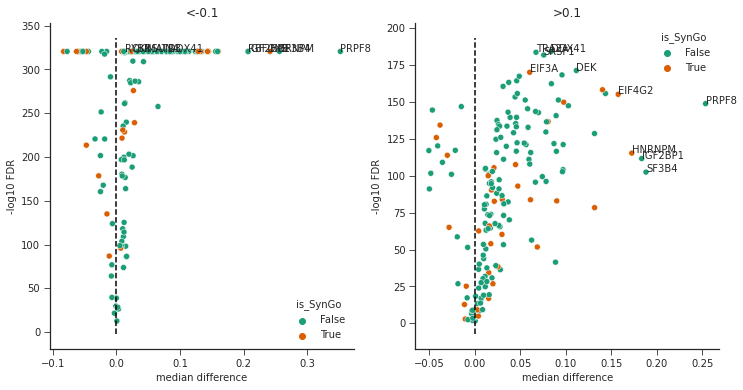

In [48]:
f, axes = plt.subplots(1,2, figsize = (12,6))
for ax, (name, group) in zip(axes.flatten(),stat_all.groupby(by = ['category'])):
    sns.scatterplot(data = group, x = 'median difference', y = '-log10 FDR', ax = ax, hue = 'is_SynGo')
    ax.set_title(name)
    sig1 = group.loc[(group['sig'])].sort_values(by = 'median difference', ascending = False).iloc[:5]
    sig2 = group.loc[(group['sig'])].sort_values(by = '-log10 FDR', ascending = False).iloc[:5]
    sig = pd.concat([sig1, sig2], axis = 0)
    for index, row in sig.iterrows():
        ax.text(row['median difference'], row['-log10 FDR'], row['RBPNet_model'].split('_')[0])
    ax.vlines(x = 0, ymin = ax.get_ylim()[0],ymax = ax.get_ylim()[1], linestyle = 'dashed', color = 'black')
sns.despine()

In [32]:
stat_all.loc[stat_all['RBPNet_model'].str.contains('ELAV')]

,KS statistics,pvalue,RBPNet_model,category,median difference,sig,FDR,-log10 FDR
250,0.107778,5.627408e-136,ELAVL1_HepG2_4083,<-0.1,-0.014918,True,1.063980e-135,134.973067
251,0.085575,5.769114e-26,ELAVL1_HepG2_4083,>0.1,-0.009341,True,6.277086e-26,25.202242


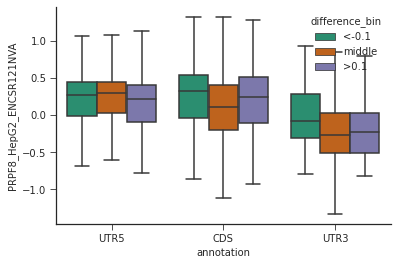

In [34]:
sns.boxplot(data, x = 'annotation', 
            y = 'PRPF8_HepG2_ENCSR121NVA', 
            hue = 'difference_bin', 
            showfliers=False)
sns.despine()

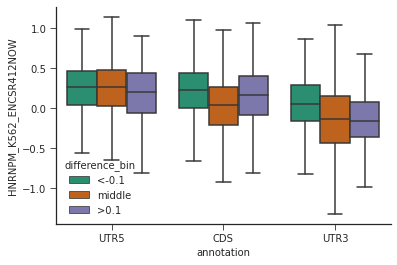

In [35]:
sns.boxplot(data, x = 'annotation', 
            y = 'HNRNPM_K562_ENCSR412NOW', 
            hue = 'difference_bin', 
            showfliers=False)
sns.despine()

In [9]:

stat = []
for exp in data.columns[9:-2]:
    for annotation in ['UTR5', 'CDS', 'UTR3']:
        for cat in ['<-0.1', '>0.1']:
            ks, pv = ks_2samp(data.loc[(data['annotation']==annotation)&
                                        (data['difference_bin']==cat),
                                        exp], 
                                        data.loc[(data['annotation']==annotation)&
                                        (data['difference_bin']=='middle'),
                                        exp], alternative='two-sided')
            stat.append([ks, pv, exp, cat, annotation])
        
    

In [10]:
stat = pd.DataFrame(stat, columns = ['KS statistics', 'pvalue', 'RBPNet_model', 'category', 'annotation'])

In [11]:
stat

,KS statistics,pvalue,RBPNet_model,category,annotation
0,0.028681,6.832860e-01,DDX41_K562_5081,<-0.1,UTR5
1,0.034531,7.661756e-01,DDX41_K562_5081,>0.1,UTR5
2,0.046089,1.816721e-28,DDX41_K562_5081,<-0.1,CDS
3,0.029865,1.954611e-02,DDX41_K562_5081,>0.1,CDS
4,0.186890,5.382955e-08,DDX41_K562_5081,<-0.1,UTR3
...,...,...,...,...,...
1033,0.061878,1.189826e-01,ZNF800_K562_ENCSR586DGV,>0.1,UTR5
1034,0.132168,9.502480e-232,ZNF800_K562_ENCSR586DGV,<-0.1,CDS
1035,0.030986,1.372807e-02,ZNF800_K562_ENCSR586DGV,>0.1,CDS
1036,0.084030,5.846302e-02,ZNF800_K562_ENCSR586DGV,<-0.1,UTR3


In [12]:
stat.sort_values(by = 'pvalue')

,KS statistics,pvalue,RBPNet_model,category,annotation
518,0.276152,0.000000,SFPQ_HepG2_ENCSR965DLL,<-0.1,CDS
824,0.238017,0.000000,PTBP1_K562_ENCSR981WKN,<-0.1,CDS
338,0.337973,0.000000,NONO_K562_4001,<-0.1,CDS
980,0.189231,0.000000,GTF2F1_HepG2_ENCSR265ZIS,<-0.1,CDS
104,0.263543,0.000000,PRPF39_HepG2_4149,<-0.1,CDS
...,...,...,...,...,...
967,0.028519,0.921011,NONO_HepG2_4084,>0.1,UTR5
31,0.028510,0.921193,PRK2_K562_5064,>0.1,UTR5
858,0.020811,0.948288,SF3B4_K562_ENCSR267OLV,<-0.1,UTR5
288,0.020661,0.951202,PDCD4_K562_5075,<-0.1,UTR5


In [13]:
stat

,KS statistics,pvalue,RBPNet_model,category,annotation
0,0.028681,6.832860e-01,DDX41_K562_5081,<-0.1,UTR5
1,0.034531,7.661756e-01,DDX41_K562_5081,>0.1,UTR5
2,0.046089,1.816721e-28,DDX41_K562_5081,<-0.1,CDS
3,0.029865,1.954611e-02,DDX41_K562_5081,>0.1,CDS
4,0.186890,5.382955e-08,DDX41_K562_5081,<-0.1,UTR3
...,...,...,...,...,...
1033,0.061878,1.189826e-01,ZNF800_K562_ENCSR586DGV,>0.1,UTR5
1034,0.132168,9.502480e-232,ZNF800_K562_ENCSR586DGV,<-0.1,CDS
1035,0.030986,1.372807e-02,ZNF800_K562_ENCSR586DGV,>0.1,CDS
1036,0.084030,5.846302e-02,ZNF800_K562_ENCSR586DGV,<-0.1,UTR3


In [14]:
#https://www.syngoportal.org/gene_hgnc10774
#SynpatomeDB, synsysnet, integrated synapse proteome

<AxesSubplot:>

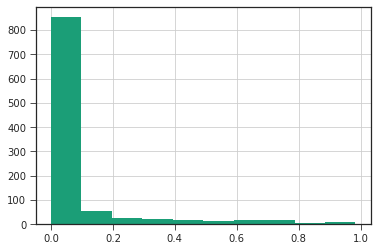

In [15]:
stat['pvalue'].hist()

<AxesSubplot:xlabel='ZNF800_K562_ENCSR586DGV', ylabel='difference'>

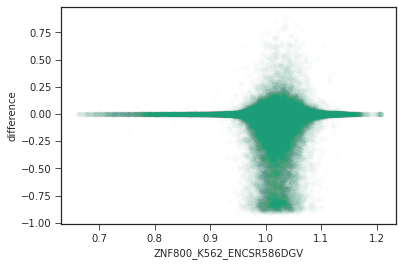

In [16]:
data.plot.scatter(x = name, y = 'difference', alpha = 0.01)